Train on 7000 samples, validate on 647 samples
Epoch 1/10
7000/7000 [==============================] - 16s 2ms/step - loss: 4.8542 - acc: 0.0056 - val_loss: 4.8516 - val_acc: 0.0124
Epoch 2/10
7000/7000 [==============================] - 16s 2ms/step - loss: 4.8510 - acc: 0.0087 - val_loss: 4.8413 - val_acc: 0.0077
Epoch 3/10
7000/7000 [==============================] - 16s 2ms/step - loss: 4.8029 - acc: 0.0194 - val_loss: 4.7129 - val_acc: 0.0355
Epoch 4/10
7000/7000 [==============================] - 16s 2ms/step - loss: 4.2824 - acc: 0.0860 - val_loss: 3.8011 - val_acc: 0.1561
Epoch 5/10
7000/7000 [==============================] - 16s 2ms/step - loss: 3.0267 - acc: 0.2910 - val_loss: 2.4599 - val_acc: 0.4019
Epoch 6/10
7000/7000 [==============================] - 16s 2ms/step - loss: 1.6054 - acc: 0.5833 - val_loss: 1.3376 - val_acc: 0.6399
Epoch 7/10
7000/7000 [==============================] - 16s 2ms/step - loss: 0.6862 - acc: 0.8163 - val_loss: 1.0464 - val_acc: 0.7249
Epoch 8/

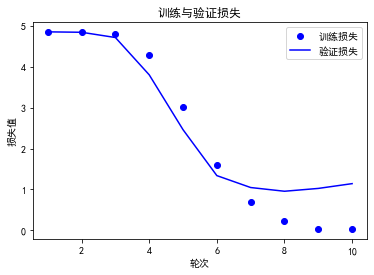

647/647 [==============================] - 1s 1ms/step
test_acc: 0.791344667789188


In [4]:
# Python 3.7.4
# Handwritten Chinese Character Classification

from gnt import GNT
import os
import zipfile
import numpy as np
import tensorflow
from PIL import Image
from keras import models
from keras import layers
from matplotlib import pyplot as plt
from keras.utils import to_categorical

# step = 1246991  # 全局变量，每次处理step个图片，防止占用太多内存，可以根据实际情况更改
step_train = 7000  # 全局变量，每次处理step个图片，防止占用太多内存，可以根据实际情况更改
step_test = 647
threshold = 220  # 二值图阈值
TargetSize = 64  # 目标图片的边长
train_times = 10  # 迭代次数

# 从数据集中提取部分样本
def GetPictures(gnt, imgs, labels):
    for img, label in gnt:
        imgs.append(img)
        labels.append(label)

# 将灰度图转为二值图    
def Gray2binary(table, img):
    img = img.convert('P')
    img = img.point(table, '1')
    return img

# 处理中文标签
def StrL2IntL(labels, labels_str):
    if labels[i] in labels_str:
        labels[i] = labels_str.index(labels[i])
    else:
        labels_str.append(labels[i])
        labels[i] = len(labels_str) - 1

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# path为数据集目录
root = 'D:\data\课程\人工智能\手写文本数据库'
# file为文件名
file = 'competition-gnt.zip'

Z = zipfile.ZipFile(f'{root}\{file}')  # 数据集为压缩包形式

imgs = []
labels = []
labels_str = []

for i in range (0, 60):
    set_name = Z.namelist()[i]  # 取压缩包中的第i个数据集
    gnt = GNT(Z, set_name)  # gnt即包含了目标数据集中的所有数据，形式为：(img, label)
    GetPictures(gnt, imgs, labels)  # 获取数据集中的step个训练数据

sub_labels = labels[0:128]
sub_imgs = imgs[0:128]
img = 128
for i in labels[128:-1]:
    if i in sub_labels:
        sub_labels.append(i)
        sub_imgs.append(imgs[img])
    img = img + 1

imgs_train = sub_imgs[0: step_train]
labels_train = sub_labels[0: step_train]
imgs_test = sub_imgs[step_train: step_train + step_test]
labels_test = sub_labels[step_train: step_train + step_test]

table = []
for i in range(256):
    if i < threshold:
        table.append(0)
    else:
        table.append(1)

# 训练数据集
for i in range(0, step_train):  # 统一图片大小
    imgs_train[i] = Image.fromarray(imgs_train[i])
    # imgs[i] = Gray2binary(table, imgs[i])  # 将灰度图转为二值图
    imgs_train[i] = imgs_train[i].resize((TargetSize, TargetSize))
    imgs_train[i] = np.array(imgs_train[i])
    StrL2IntL(labels_train, labels_str)  # 处理中文标签

# 测试数据集
for i in range(0, step_test):  # 统一图片大小
    imgs_test[i] = Image.fromarray(imgs_test[i])
    # imgs_test[i] = Gray2binary(table, imgs_test[i])  # 将灰度图转为二值图
    imgs_test[i] = imgs_test[i].resize((TargetSize, TargetSize))
    imgs_test[i] = np.array(imgs_test[i])
    StrL2IntL(labels_test, labels_str)  # 处理中文标签

# 改变张量形状
imgs_train = np.array(imgs_train)
'''
imgs = imgs.reshape((step, TargetSize * TargetSize))
'''
imgs_train = imgs_train.reshape((step_train, TargetSize, TargetSize, 1))
imgs_train = imgs_train.astype("float") / 255
imgs_test = np.array(imgs_test)
'''
imgs_test = imgs_test.reshape((step_test, TargetSize * TargetSize))
'''
imgs_test = imgs_test.reshape((step_test, TargetSize, TargetSize, 1))
imgs_test = imgs_test.astype("float") / 255

# 构建网络
network = models.Sequential()
network.add(layers.Conv2D(256, (3, 3), activation='relu', input_shape=(TargetSize, TargetSize, 1)))
network.add(layers.MaxPooling2D((2, 2)))
network.add(layers.Conv2D(256, (3, 3), activation='relu'))
network.add(layers.MaxPooling2D((2, 2)))
network.add(layers.Conv2D(512, (3, 3), activation='relu'))
network.add(layers.MaxPooling2D((2, 2)))
network.add(layers.Flatten())
network.add(layers.Dense(512, activation='relu'))
network.add(layers.Dense(len(labels_str), activation='softmax'))

# 编译
network.compile(optimizer = 'adadelta', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# 训练
labels_train = np.array(labels_train)
labels_train = to_categorical(labels_train)
labels_test = np.array(labels_test)
labels_test = to_categorical(labels_test)
history = network.fit(imgs_train, labels_train, epochs=train_times, batch_size=128, validation_data=(imgs_test, labels_test))

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label = '训练损失')
plt.plot(epochs, val_loss_values, 'b', label = '验证损失')
plt.title('训练与验证损失')
plt.xlabel('轮次')
plt.ylabel('损失值')
plt.legend()
plt.show()

# 测试
test_loss, test_acc = network.evaluate(imgs_test, labels_test)
network.save('HCCC_subset.h5')
print('test_acc:', test_acc)